In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [22]:
# load the cleaned dataset
data_path = "cleaned_diabetic_data.csv"
df = pd.read_csv(data_path)
df.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,readmitted,readmitted_binary,admission_type,discharge_disposition,admission_source,diag_1_group,diag_2_group,diag_3_group,med_count,age_numeric
0,12522,48330783,Caucasian,Female,[80-90),2,1,4,13,68,...,NO,0,Urgent,Discharged to home,Transfer from hospital,Circulatory,Circulatory,Infectious and parasitic diseases,2,85
1,15738,63555939,Caucasian,Female,[90-100),3,3,4,12,33,...,NO,0,Elective,To SNF,Transfer from hospital,Circulatory,Neoplasms,Respiratory,2,95
2,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,51,...,NO,0,Emergency,Discharged to home,Emergency Room,Neoplasms,Neoplasms,Diabetes,2,45
3,28236,89869032,AfricanAmerican,Female,[40-50),1,1,7,9,47,...,>30,0,Emergency,Discharged to home,Emergency Room,Diabetes,Circulatory,Injury,1,45
4,35754,82637451,Caucasian,Male,[50-60),2,1,2,3,31,...,>30,0,Urgent,Discharged to home,Clinic Referral,Circulatory,Circulatory,Diabetes,1,55


In [ ]:
# Lets build a xgboost model to predict readmission
import xgboost as xgb
from sklearn.model_selection import train_test_split

# Define features and target variable

X = df.drop(columns=['readmitted_binary', 'diag_1', 'diag_2', 'diag_3', 'age', 'encounter_id', 'patient_nbr', 'readmitted', 'num_lab_procedures', 'discharge_disposition', 'admission_source', 'admission_type'])
y = df['readmitted_binary']

X_encoded = pd.get_dummies(X, drop_first=True)


# Split the dataset into training and testing and validation sets
X_train, X_temp, y_train, y_temp = train_test_split(X_encoded, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# apply balancing to the training set
from imblearn.combine import SMOTEENN
X_train, y_train = SMOTEENN(random_state=42).fit_resample(X_train, y_train)


def train_xgboost_model(X_train, y_train, random_seed=42, scale_pos_weight=None):
    xgb_model = xgb.XGBClassifier(
        random_state=random_seed,
        eval_metric="logloss",
        enable_categorical=True,
        n_estimators=100,
        scale_pos_weight=scale_pos_weight
    )

    # Fit the model
    xgb_model.fit(X_train, y_train)
    return xgb_model

# Train the model
xgb_model = train_xgboost_model(X_train, y_train)
# Evaluate the model on the validation set
from sklearn.metrics import accuracy_score, classification_report

y_proba = xgb_model.predict_proba(X_val)[:, 1]
for threshold in [0.5, 0.4, 0.3, 0.2]:
    y_pred = (y_proba >= threshold).astype(int)
    print(f"\nThreshold: {threshold}")
    print(classification_report(y_val, y_pred))


Threshold: 0.5
              precision    recall  f1-score   support

           0       0.92      0.91      0.91      9539
           1       0.18      0.21      0.19       959

    accuracy                           0.84     10498
   macro avg       0.55      0.56      0.55     10498
weighted avg       0.85      0.84      0.85     10498


Threshold: 0.4
              precision    recall  f1-score   support

           0       0.92      0.84      0.88      9539
           1       0.15      0.28      0.20       959

    accuracy                           0.79     10498
   macro avg       0.54      0.56      0.54     10498
weighted avg       0.85      0.79      0.82     10498


Threshold: 0.3
              precision    recall  f1-score   support

           0       0.92      0.76      0.83      9539
           1       0.14      0.39      0.20       959

    accuracy                           0.73     10498
   macro avg       0.53      0.57      0.52     10498
weighted avg       0.85   

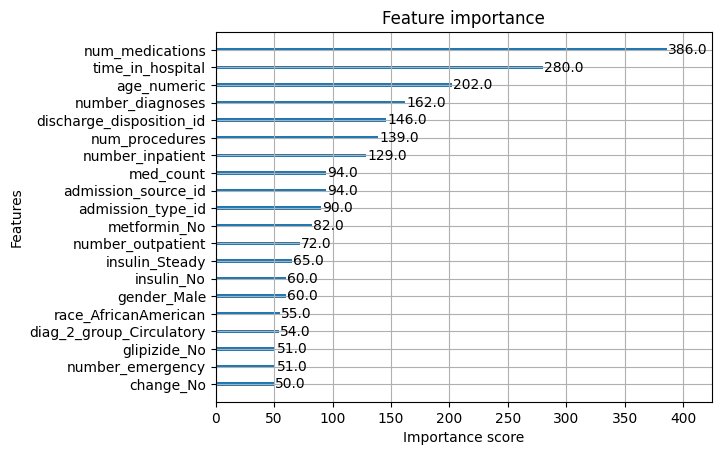

In [13]:
xgb.plot_importance(xgb_model, max_num_features=20)
plt.show()

/Users/bosky/boskymsaiicoursework/src/module2-assginment/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


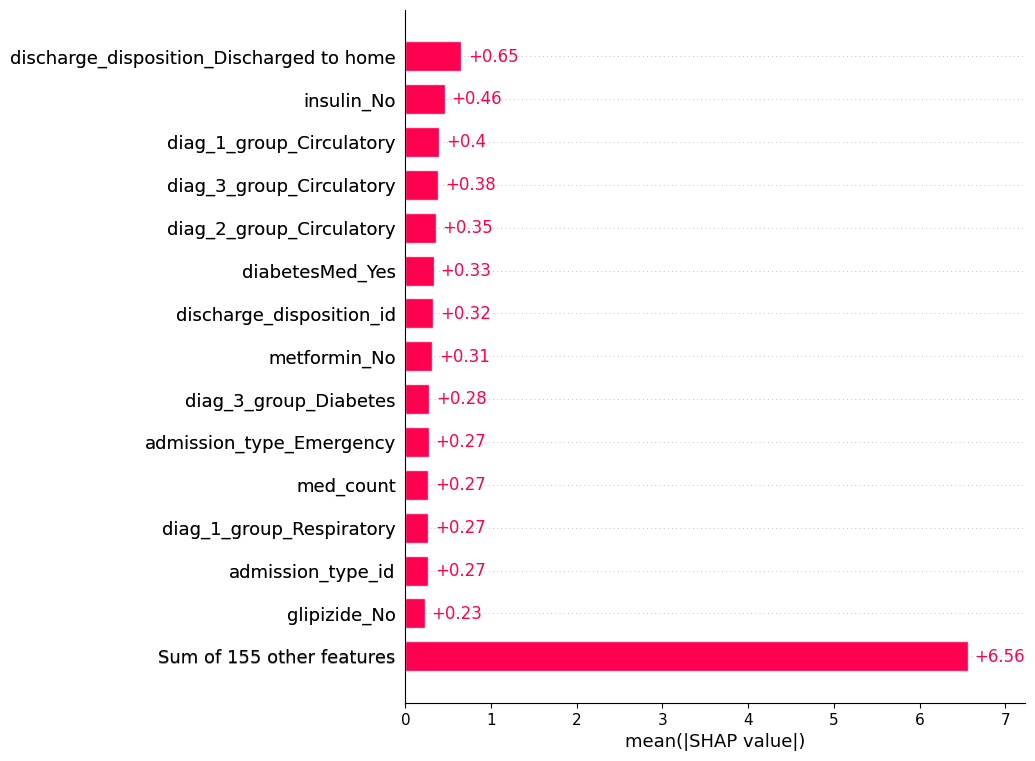

In [11]:
import shap

explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_val)

shap.plots.bar(shap_values, max_display=15)

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

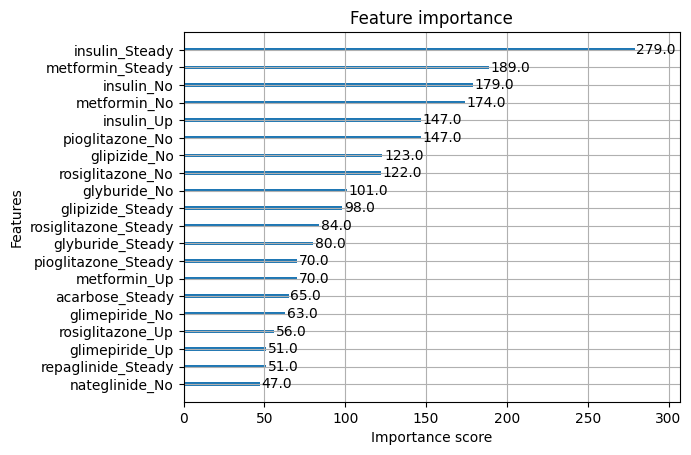

In [15]:
med_cols = [ 'metformin','repaglinide','nateglinide','chlorpropamide','glimepiride','acetohexamide','glipizide','glyburide','tolbutamide','pioglitazone','rosiglitazone','acarbose','miglitol','troglitazone','tolazamide','examide','citoglipton','insulin','glyburide-metformin','glipizide-metformin','glimepiride-pioglitazone','metformin-rosiglitazone','metformin-pioglitazone']
med_features = df[med_cols]
med_features_encoded = pd.get_dummies(med_features, drop_first=True)

xgb_med = xgb.XGBClassifier(eval_metric='logloss')
xgb_med.fit(med_features_encoded, y)

xgb.plot_importance(xgb_med, max_num_features=20)

In [25]:
def create_med_aggregates(df, med_cols):
    # Count how many meds are 'Up' or 'Down' (changed dose)
    df['meds_changed'] = df[med_cols].apply(lambda row: row.isin(['Up', 'Down']).sum(), axis=1)
    return df


df = create_med_aggregates(df, med_cols)
X = df.drop(columns=med_cols + ['readmitted_binary', 'diag_1', 'diag_2', 'diag_3', 'age', 'encounter_id', 'patient_nbr', 'readmitted','discharge_disposition', 'admission_source', 'admission_type'])
X = pd.get_dummies(X, drop_first=True)  # for other categorical features

X['meds_changed'] = df['meds_changed']

X_train, y_train = SMOTEENN(random_state=42).fit_resample(X_train, y_train)
# Train the model
xgb_model = train_xgboost_model(X_train, y_train)
# Evaluate the model on the validation set
from sklearn.metrics import accuracy_score, classification_report

y_proba = xgb_model.predict_proba(X_val)[:, 1]
for threshold in [0.5, 0.4, 0.3, 0.2]:
    y_pred = (y_proba >= threshold).astype(int)
    print(f"\nThreshold: {threshold}")
    print(classification_report(y_val, y_pred))



Threshold: 0.5
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      9539
           1       0.18      0.21      0.19       959

    accuracy                           0.84     10498
   macro avg       0.55      0.56      0.55     10498
weighted avg       0.85      0.84      0.84     10498


Threshold: 0.4
              precision    recall  f1-score   support

           0       0.92      0.84      0.88      9539
           1       0.16      0.30      0.21       959

    accuracy                           0.79     10498
   macro avg       0.54      0.57      0.54     10498
weighted avg       0.85      0.79      0.82     10498


Threshold: 0.3
              precision    recall  f1-score   support

           0       0.93      0.75      0.83      9539
           1       0.14      0.41      0.21       959

    accuracy                           0.72     10498
   macro avg       0.53      0.58      0.52     10498
weighted avg       0.86   

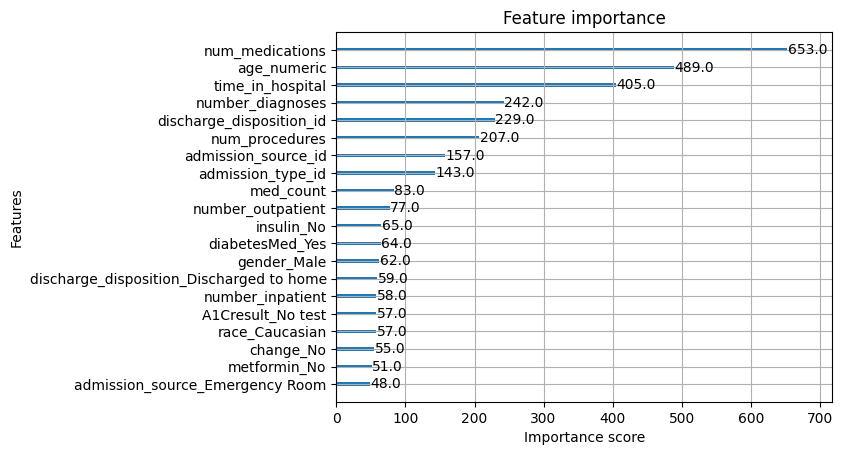

In [24]:
xgb.plot_importance(xgb_model, max_num_features=20)
plt.show()